<a href="https://colab.research.google.com/github/YuuyaKazuya/AssignmentIS/blob/main/XAU_USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install lightgbm scikit-learn pandas matplotlib

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import early_stopping
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [3]:
file1 = "/content/drive/MyDrive/PSM/XAUUSD1440.xlsx"
file2 = "/content/drive/MyDrive/PSM/10_Technical_Indicators.xlsx"
file3 = "/content/drive/MyDrive/PSM/XAUUSD1440_trend.xlsx"
file4 = "/content/drive/MyDrive/PSM/10_Technical_Indicators_Discrete.xlsx"

df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)
df3 = pd.read_excel(file3)
df4 = pd.read_excel(file4)

In [4]:
# prompt: check features in df

print(df1.columns)
print(df2.columns)
print(df3.columns)
df4.columns


Index(['Date', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'], dtype='object')
Index(['Date', 'SMA', 'WMA', 'Momentum', 'StochasticK', 'StochasticD', 'RSI',
       'MACDLine', 'SignalLine', 'WilliamsR', 'A_D', 'CCI'],
      dtype='object')
Index(['Date', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'TREND'], dtype='object')


Index(['Date', 'SMA_Discrete', 'WMA_Discrete', 'Mom_Discrete', 'Discrete_K',
       'Discrete_D', 'RSI_Discrete', 'MACD_Discrete', 'LW_Discrete',
       'A_D_Discrete', 'CCI_Discrete'],
      dtype='object')

In [6]:
features1 = df2[['SMA', 'WMA', 'Momentum', 'StochasticK', 'StochasticD', 'RSI', 'MACDLine', 'SignalLine', 'WilliamsR', 'A_D', 'CCI']]
target1 = df1['CLOSE']  # Replace with the actual target column

features2 = df4[['SMA_Discrete', 'WMA_Discrete', 'Mom_Discrete', 'Discrete_K', 'Discrete_D', 'RSI_Discrete', 'MACD_Discrete', 'LW_Discrete',
       'A_D_Discrete', 'CCI_Discrete']]
target2 = df3['TREND']  # Replace with the actual target column


In [7]:
df1['Date'] = pd.to_datetime(df1['Date'])
df2['Date'] = pd.to_datetime(df2['Date'])
df3['Date'] = pd.to_datetime(df3['Date'])
df4['Date'] = pd.to_datetime(df4['Date'])

# Merge the datasets on the Date column
merged_df1 = pd.merge(df2, df1[['Date', 'CLOSE']], on='Date', how='inner')
merged_df2 = pd.merge(df4, df3[['Date', 'TREND']], on='Date', how='inner')

# Update features and target after merge
features1 = merged_df1[['SMA', 'WMA', 'Momentum', 'StochasticK', 'StochasticD', 'RSI', 'MACDLine', 'SignalLine', 'WilliamsR', 'A_D', 'CCI']]
target1 = merged_df1['CLOSE']

features2 = merged_df2[['SMA_Discrete', 'WMA_Discrete', 'Mom_Discrete', 'Discrete_K', 'Discrete_D', 'RSI_Discrete', 'MACD_Discrete', 'LW_Discrete',
       'A_D_Discrete', 'CCI_Discrete']]
target2 = merged_df2['TREND']

In [10]:
# cLOSING PRICE
X_train1, X_test1, y_train1, y_test1 = train_test_split(features1, target1, test_size=0.2, random_state=42)

# DISCRETE (+1, -1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2, random_state=42)

In [15]:
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model1.fit(X_train1, y_train1)
rf_predictions1 = rf_model1.predict(X_test1)

imputer = SimpleImputer(strategy='most_frequent')  # Use 'most_frequent' for discrete target
y_train2_imputed = imputer.fit_transform(y_train2.values.reshape(-1, 1))  # Reshape for imputer
y_train2 = pd.Series(y_train2_imputed.flatten(), index=y_train2.index)  # Convert back to Series

# Now you can fit the model
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2.fit(X_train2, y_train2)
rf_predictions2 = rf_model2.predict(X_test2)

In [18]:
imputer1 = SimpleImputer(strategy='mean') # Create an imputer instance
X_train_imputed1 = imputer.fit_transform(X_train1) # Fit and transform on training data
X_test_imputed1 = imputer.transform(X_test1) # Transform test data using the same imputer

svm_model1 = SVR(kernel='rbf')
svm_model1.fit(X_train_imputed1, y_train1) # Use imputed training data
svm_predictions1 = svm_model1.predict(X_test_imputed1) # Use imputed test data

imputer2 = SimpleImputer(strategy='mean') # Create an imputer instance
X_train_imputed2 = imputer.fit_transform(X_train1) # Fit and transform on training data
X_test_imputed2 = imputer.transform(X_test1) # Transform test data using the same imputer

svm_model2 = SVR(kernel='rbf')
svm_model2.fit(X_train_imputed2, y_train2) # Use imputed training data
svm_predictions2 = svm_model2.predict(X_test_imputed2) # Use imputed test data

In [20]:
# Hyperparameter Tuning for LightGBM using GridSearchCV
param_grid = {
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgb_model1 = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31)
lgb_model2 = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31)

# Train the model with early stopping using callbacks
lgb_model1.fit(X_train1, y_train1,
              eval_set=[(X_test1, y_test1)],
              eval_metric='l1', # or any other suitable metric
              callbacks=[early_stopping(stopping_rounds=50)]) # Use early_stopping callback

# Predict and evaluate
lgb_predictions1 = lgb_model1.predict(X_test1)
lgb_mae1 = mean_absolute_error(y_test1, lgb_predictions1)
lgb_mse1 = mean_squared_error(y_test1, lgb_predictions1)
lgb_r21 = r2_score(y_test1, lgb_predictions1)

lgb_model2.fit(X_train2, y_train2,
              eval_set=[(X_test2, y_test2)],
              eval_metric='l1', # or any other suitable metric
              callbacks=[early_stopping(stopping_rounds=50)]) # Use early_stopping callback

# Predict and evaluate
lgb_predictions2 = lgb_model2.predict(X_test2)
lgb_mae2 = mean_absolute_error(y_test2, lgb_predictions2)
lgb_mse2 = mean_squared_error(y_test2, lgb_predictions2)
lgb_r22 = r2_score(y_test2, lgb_predictions2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 4149, number of used features: 11
[LightGBM] [Info] Start training from score 1463.899532
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's l1: 5.3382	valid_0's l2: 65.8496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 4149, number of used features: 10
[LightGBM] [Info] Start training from score 0.049892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:

In [21]:
rf_mae1 = mean_absolute_error(y_test1, rf_predictions1)
svm_mae1 = mean_absolute_error(y_test1, svm_predictions1)
lgb_mae1 = mean_absolute_error(y_test1, lgb_predictions1)

rf_mse1 = mean_squared_error(y_test1, rf_predictions1)
svm_mse1 = mean_squared_error(y_test1, svm_predictions1)
lgb_mse1 = mean_squared_error(y_test1, lgb_predictions1)

rf_r21 = r2_score(y_test1, rf_predictions1)
svm_r21 = r2_score(y_test1, svm_predictions1)
lgb_r21 = r2_score(y_test1, lgb_predictions1)

rf_mae2 = mean_absolute_error(y_test2, rf_predictions2)
svm_mae2 = mean_absolute_error(y_test2, svm_predictions2)
lgb_mae2 = mean_absolute_error(y_test2, lgb_predictions2)

rf_mse2 = mean_squared_error(y_test2, rf_predictions2)
svm_mse2 = mean_squared_error(y_test2, svm_predictions2)
lgb_mse2 = mean_squared_error(y_test2, lgb_predictions2)

rf_r22 = r2_score(y_test2, rf_predictions2)
svm_r22 = r2_score(y_test2, svm_predictions2)
lgb_r22 = r2_score(y_test2, lgb_predictions2)

In [27]:
print(f"Random Forest MAE: {rf_mae1}")
print(f"SVM MAE: {svm_mae1}")
print(f"LightGBM MAE: {lgb_mae1}")
print(f" ")
print(f"Random Forest MSE: {rf_mse1}")
print(f"SVM MSE: {svm_mse1}")
print(f"LightGBM MSE: {lgb_mse1}")
print(f" ")
print(f"Random Forest R²: {rf_r21}")
print(f"SVM R²: {svm_r21}")
print(f"LightGBM R²: {lgb_r21}")

print(f" ")
print(f"Discrete Trend Result:- ")
print(f" ")

print(f"Random Forest MAE: {rf_mae2}")
print(f"SVM MAE: {svm_mae2}")
print(f"LightGBM MAE: {lgb_mae2}")
print(f" ")
print(f"Random Forest MSE: {rf_mse2}")
print(f"SVM MSE: {svm_mse2}")
print(f"LightGBM MSE: {lgb_mse2}")
print(f" ")
print(f"Random Forest R²: {rf_r22}")
print(f"SVM R²: {svm_r22}")
print(f"LightGBM R²: {lgb_r22}")

Random Forest MAE: 6.160502244701353
SVM MAE: 171.35176231698446
LightGBM MAE: 5.338198294266622
 
Random Forest MSE: 93.7569242771315
SVM MSE: 49927.48959567437
LightGBM MSE: 65.84959003763221
 
Random Forest R²: 0.9993621039293002
SVM R²: 0.6603072287349858
LightGBM R²: 0.9995519776798775
 
Discrete Trend Result:- 
 
Random Forest MAE: 0.2911393357637241
SVM MAE: 0.9253940113464223
LightGBM MAE: 0.29986414503391606
 
Random Forest MSE: 0.3189009619579216
SVM MSE: 1.6595276002292678
LightGBM MSE: 0.30610831907707015
 
Random Forest R²: 0.6788948457865527
SVM R²: -0.6709979885962338
LightGBM R²: 0.6917759093613793


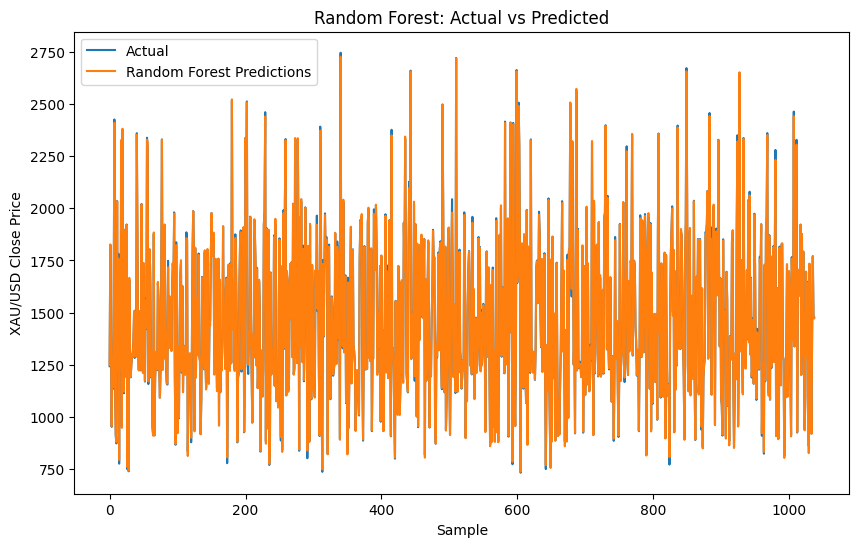

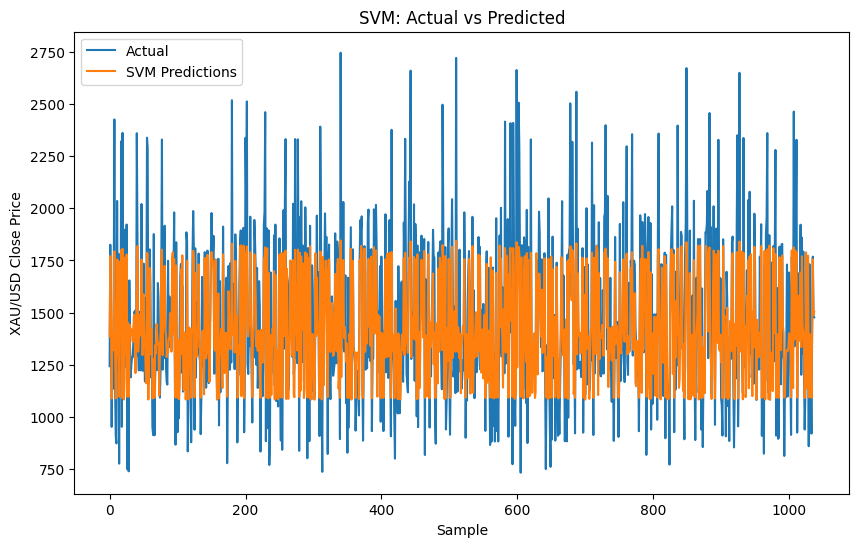

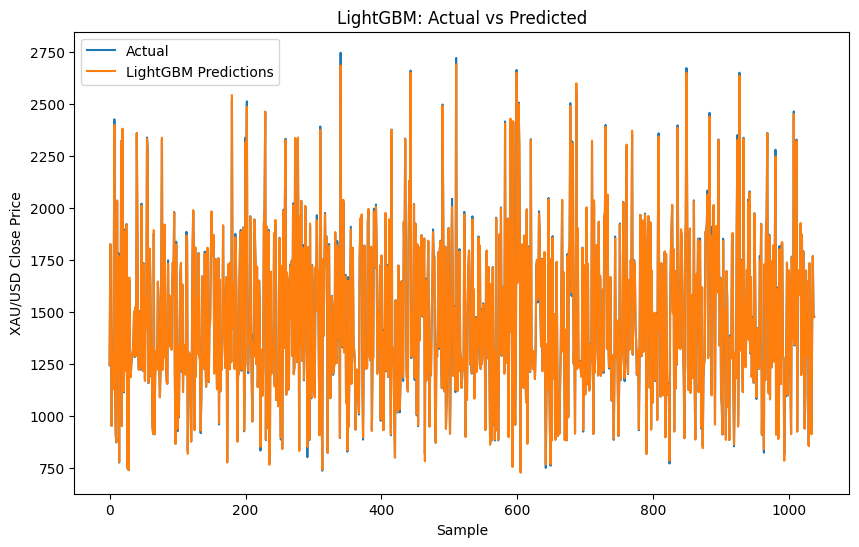

In [28]:
# Plot for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(y_test1.values, label="Actual")
plt.plot(rf_predictions1, label="Random Forest Predictions")
plt.legend()
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Sample")
plt.ylabel("XAU/USD Close Price")
plt.show()

# Plot for SVM
plt.figure(figsize=(10, 6))
plt.plot(y_test1.values, label="Actual")
plt.plot(svm_predictions1, label="SVM Predictions")
plt.legend()
plt.title("SVM: Actual vs Predicted")
plt.xlabel("Sample")
plt.ylabel("XAU/USD Close Price")
plt.show()

# Plot for LightGBM
plt.figure(figsize=(10, 6))
plt.plot(y_test1.values, label="Actual")
plt.plot(lgb_predictions1, label="LightGBM Predictions")
plt.legend()
plt.title("LightGBM: Actual vs Predicted")
plt.xlabel("Sample")
plt.ylabel("XAU/USD Close Price")
plt.show()

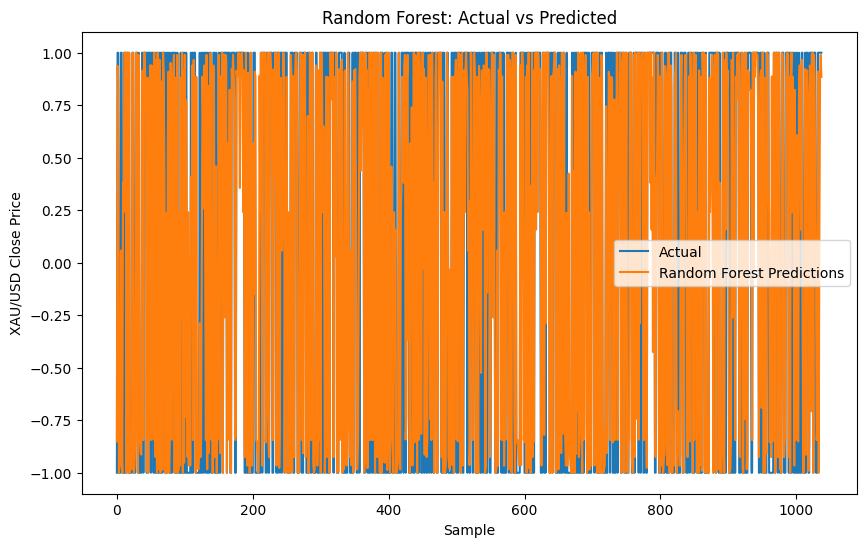

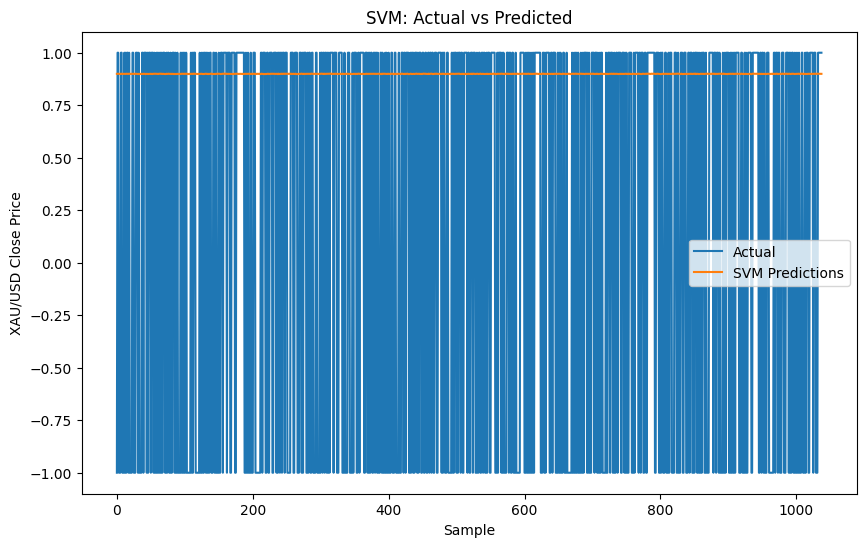

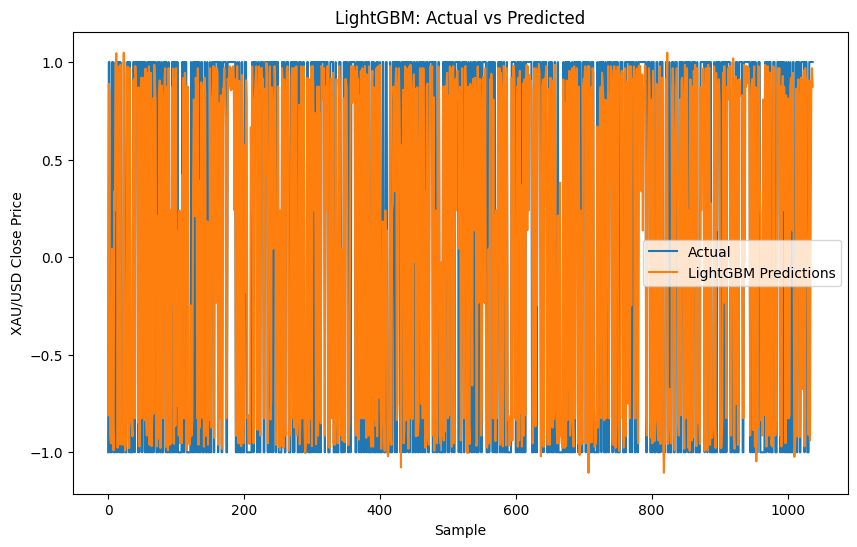

In [29]:
# Plot for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(y_test2.values, label="Actual")
plt.plot(rf_predictions2, label="Random Forest Predictions")
plt.legend()
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Sample")
plt.ylabel("XAU/USD Close Price")
plt.show()

# Plot for SVM
plt.figure(figsize=(10, 6))
plt.plot(y_test2.values, label="Actual")
plt.plot(svm_predictions2, label="SVM Predictions")
plt.legend()
plt.title("SVM: Actual vs Predicted")
plt.xlabel("Sample")
plt.ylabel("XAU/USD Close Price")
plt.show()

# Plot for LightGBM
plt.figure(figsize=(10, 6))
plt.plot(y_test2.values, label="Actual")
plt.plot(lgb_predictions2, label="LightGBM Predictions")
plt.legend()
plt.title("LightGBM: Actual vs Predicted")
plt.xlabel("Sample")
plt.ylabel("XAU/USD Close Price")
plt.show()

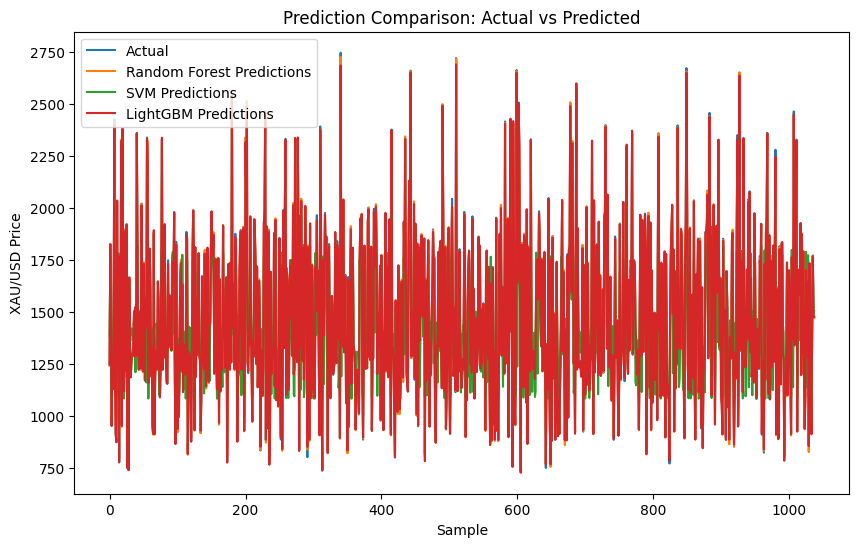

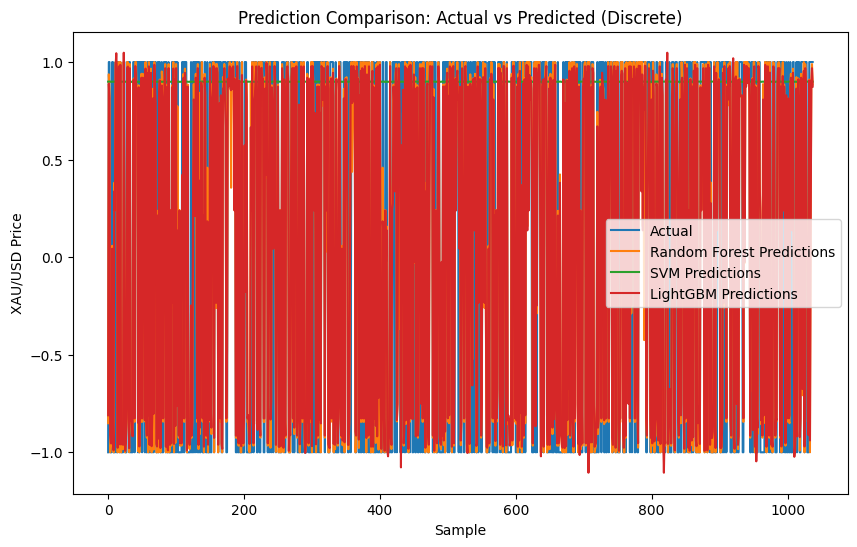

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(y_test1.values, label="Actual")
plt.plot(rf_predictions1, label="Random Forest Predictions")
plt.plot(svm_predictions1, label="SVM Predictions")
plt.plot(lgb_predictions1, label="LightGBM Predictions")
plt.legend()
plt.title("Prediction Comparison: Actual vs Predicted")
plt.xlabel("Sample")
plt.ylabel("XAU/USD Price")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test2.values, label="Actual")
plt.plot(rf_predictions2, label="Random Forest Predictions")
plt.plot(svm_predictions2, label="SVM Predictions")
plt.plot(lgb_predictions2, label="LightGBM Predictions")
plt.legend()
plt.title("Prediction Comparison: Actual vs Predicted (Discrete)")
plt.xlabel("Sample")
plt.ylabel("XAU/USD Price")
plt.show()